# Make tour allocation estimation file
use 2017 NHTS to create a choice model estimation file to allocate tours to specific vehicles


In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_rows = 999
pd.options.display.max_columns = 500
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# read the basic data
hh   = pd.read_csv('hhpub.csv')
pers = pd.read_csv('perpub.csv')
veh  = pd.read_csv('vehpub.csv')

# tour data as processed by Mark
tours = pd.read_csv('nhts_auto_hbtours.csv')

# attributes by vehicle type
veh_attributes = pd.read_csv('epa_vehicle_data.csv')

### Calculate several derived fields and merge the HH and person files with the vehicles file

In [3]:
# define person type

def determine_person_type(row):
    
    # children under 5 not included in NHTS data
    if row['R_AGE_IMP']<=4: 
        return 'Child0_4'
    
    # children 5-15
    elif row['R_AGE_IMP']<=15: 
        return 'Child5_15'
    
    # children 16-17
    elif row['R_AGE_IMP']<=17:
        return 'Child16p'
    
    # school type in NHTS stops at age 17, so it's not clear how to identify college students
    elif row['SCHTYP']==1: 
        return 'CollegeStudent'
    
    # full-time workers
    elif row['WKFTPT']==1: 
        return 'FullTimeWorker'
    
    # part-time workers
    elif row['WKFTPT']==2:
        return 'PartTimeWorker'
    
    # non-working adults age <65
    elif row['R_AGE_IMP']<65:
        return 'NonWorkingAdultUnder65'
    
    # non-working adults age >=65
    else:
        return 'NonWorkingAdult65p'

pers['PERSON_TYPE'] = pers.apply(determine_person_type, axis=1)

In [4]:
# define person type

def determine_numeric_person_type(row):
    
    # children under 5 not included in NHTS data
    if row['R_AGE_IMP']<=4: 
        return 1
    
    # children 5-15
    elif row['R_AGE_IMP']<=15: 
        return 2
    
    # children 16-17
    elif row['R_AGE_IMP']<=17:
        return 3
    
    # school type in NHTS stops at age 17, so it's not clear how to identify college students
    elif row['SCHTYP']==1: 
        return 4
    
    # full-time workers
    elif row['WKFTPT']==1: 
        return 5
    
    # part-time workers
    elif row['WKFTPT']==2:
        return 6
    
    # non-working adults age <65
    elif row['R_AGE_IMP']<65:
        return 7
    
    # non-working adults age >=65
    else:
        return 8

pers['PERSON_TYPE2'] = pers.apply(determine_numeric_person_type, axis=1)

In [5]:
# define person type count variables
pers['CHILDREN0_4']  = np.where(pers['PERSON_TYPE']=='Child0_4', 1, 0)
pers['CHILDREN5_15'] = np.where(pers['PERSON_TYPE']=='Child5_15', 1, 0)
pers['CHILDREN16P']  = np.where(pers['PERSON_TYPE']=='Child16p', 1, 0)
pers['COLLEGE_STUDENTS']  = np.where(pers['PERSON_TYPE']=='CollegeStudent', 1, 0)
pers['FULL_TIME_WORKERS']  = np.where(pers['PERSON_TYPE']=='FullTimeWorker', 1, 0)
pers['PART_TIME_WORKERS']  = np.where(pers['PERSON_TYPE']=='PartTimeWorker', 1, 0)
pers['NW_ADULTS_UNDER65']  = np.where(pers['PERSON_TYPE']=='NonWorkingAdultUnder65', 1, 0)
pers['NW_ADULTS_65P']  = np.where(pers['PERSON_TYPE']=='NonWorkingAdult65p', 1, 0)


In [6]:
# additional person count variables
pers['CHILDREN'] = np.where(pers['R_AGE_IMP']<18, 1, 0)
pers['WORKERS'] = np.where(((pers['WKFTPT']==1) | (pers['WKFTPT']==2)), 1, 0)
pers['PERSONS16P'] = np.where(pers['R_AGE_IMP']>=16, 1, 0)
pers['DRIVERS'] = np.where(pers['DRIVER']==1,1,0)
pers['MEN16P'] = np.where(((pers['R_AGE_IMP']>=16) & (pers['R_SEX_IMP']==1)), 1, 0)
pers['WOMEN16P'] = np.where(((pers['R_AGE_IMP']>=16) & (pers['R_SEX_IMP']==2)), 1, 0)
pers['BORN_IN_US16P'] = np.where(((pers['R_AGE_IMP']>=16) & (pers['BORNINUS']==1)), 1, 0)
pers['BORN_OUTSIDE_US16P'] = np.where(((pers['R_AGE_IMP']>=16) & (pers['BORNINUS']==2)), 1, 0)


In [7]:
# process distance to work to convert missing values to zeros
pers['DISTTOWK17'] = np.where(pers['DISTTOWK17']<0, 0, pers['DISTTOWK17'])

In [8]:
# aggregate person data to household level
person_specs = {'CHILDREN0_4' : sum, 
                'CHILDREN5_15': sum, 
                'CHILDREN16P': sum, 
                'COLLEGE_STUDENTS': sum, 
                'FULL_TIME_WORKERS': sum, 
                'PART_TIME_WORKERS': sum, 
                'NW_ADULTS_UNDER65': sum, 
                'NW_ADULTS_65P': sum, 
                'WORKERS': sum, 
                'CHILDREN': sum, 
                'PERSONS16P': sum, 
                'DRIVERS': sum, 
                'MEN16P': sum, 
                'WOMEN16P': sum, 
                'DISTTOWK17': sum
               }

pershh = pers.groupby('HOUSEID').agg(person_specs)
pershh['DISTTOWK_SUM'] = pershh['DISTTOWK17']
pershh['DISTTOWK_AVG'] = np.where(pershh['WORKERS']>0, pershh['DISTTOWK17'] / pershh['WORKERS'], 0)


### Group the alternatives into more aggregate categories, and drop records missing our choice alternatives

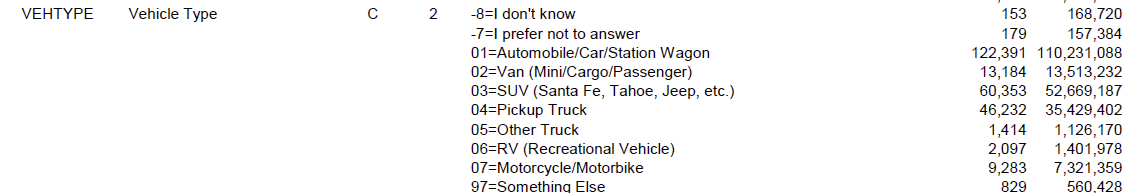

In [9]:
# group body types into more limited categories
def determine_body_type(row):
    
    # automobile/car/station wagon
    if row['VEHTYPE']==1: 
        return 1
    
    # van (Mini/Cargo/Passenger)
    elif row['VEHTYPE']==2: 
        return 2
    
    # SUV
    elif row['VEHTYPE']==3: 
        return 3
    
    # pickup/other truck
    elif row['VEHTYPE']==4 or row['VEHTYPE']==5: 
        return 4
    
    # motorcycle
    elif row['VEHTYPE']==7: 
        return 5
    
    # everything else
    else: 
        return 97
    
veh['VEHTYPE2'] = veh.apply(determine_body_type, axis=1)
veh['VEHTYPE2_TXT'] = veh['VEHTYPE2'].replace({1:'1-Car', 
                                                       2:'2-Van', 
                                                       3:'3-SUV', 
                                                       4:'4-Pickup/Truck', 
                                                       5:'5-Motorcycle', 
                                                       97:'97-Other'})

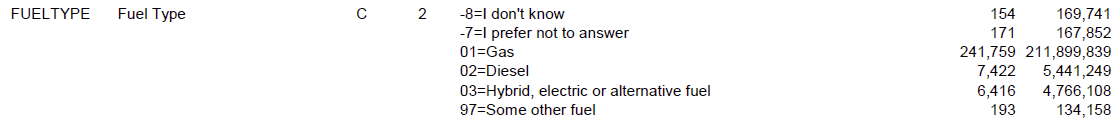
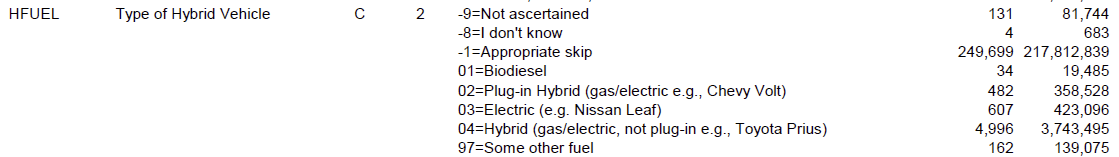

In [10]:
# group fuel types into a more limited number of categories
def determine_fuel_type(row):
    
    # gas
    if row['FUELTYPE']==1:
        return 1
    
    # diesel
    if row['FUELTYPE']==2: 
        return 2
    
    # hybrid
    elif row['FUELTYPE']==3 and row['HFUEL']==4: 
        return 3
    
    # plug-in hybrid
    elif row['FUELTYPE']==3 and row['HFUEL']==2: 
        return 4
    
    # battery-electric
    elif row['FUELTYPE']==3 and row['HFUEL']==3: 
        return 5
    
    # don't know/other
    else:
        return 97
    
veh['FUELTYPE2'] = veh.apply(determine_fuel_type, axis=1)
veh['FUELTYPE2_TXT'] = veh['FUELTYPE2'].replace({1:'1-Gas', 
                                                         2:'2-Diesel',
                                                         3:'3-Hybrid', 
                                                         4:'4-Plug-In Hybrid', 
                                                         5:'5-Battery Electric', 
                                                         97:'97-Other'})

In [11]:
# group vehicle ages into a more limited number of categories
def determine_vehicle_age_group(row):
    
    if row['VEHAGE']<0:
        return 97
    elif row['VEHAGE']<=5: 
        return 1
    elif row['VEHAGE']<=10:
        return 2
    else:
        return 3
    
veh['VEHAGE2'] = veh.apply(determine_vehicle_age_group, axis=1)
veh['VEHAGE2_TXT'] = veh['VEHAGE2'].replace({1:'1: 1-5 years', 
                                                     2:'2: 6-10 years', 
                                                     3:'3: 11+ years', 
                                                    97:'97: Missing/Unknown'})

In [12]:
# group vehicle ages into new vs used
# we probably won't use this, but it will be interesting for future use
veh['NEW_VEHICLE'] = np.where(veh['VEHOWNED']==2, 1, 0)

In [13]:
# exclude missing body types, fuel types, and age
veh = veh[veh['VEHTYPE2']!=97]
veh = veh[veh['FUELTYPE2']!=97]
veh = veh[veh['VEHAGE2']!=97]

# exclude diesel, hybrid, and PEV motorcyles b/c a tiny share and of little interest
veh = veh[(veh['VEHTYPE2']!=5) | (veh['FUELTYPE2']!=2)]
veh = veh[(veh['VEHTYPE2']!=5) | (veh['FUELTYPE2']!=3)]
veh = veh[(veh['VEHTYPE2']!=5) | (veh['FUELTYPE2']!=3)]

### Rank vehicles by how many miles they are driven

In [14]:
# rank vehicles by miles driven
veh["RANK"] = veh.groupby("HOUSEID")["BESTMILE"].rank("first", ascending=False)

In [15]:
# keep only the four vehicles in each household (limit of ActivitySim car ownership model)
# keep the vehicles that have the most mileage

veh = veh[veh['RANK']<=4]

### look at options for how we might structure the alternatives for each, consider the count of observations and the average miles driven per vehicle

In [16]:

# cap vehicle age at 20+
veh['VEHAGE_C20'] = veh['VEHAGE'].apply(lambda x : min(x,20))

# fourth choice option: vehicle type by fuel type by detailed age
veh['CHOICE4'] = 1000*veh['VEHTYPE2'] + 100*veh['FUELTYPE2'] + veh['VEHAGE_C20'] 

# also set up as an array of 1 thorugh 500 to meet ALOGIT constraints
i = 1
choice4_to_index = {}
for v in range(1,6):
    for f in range(1,6):
        for a in range(1,21):
            choice4 = 1000*v + 100*f + a            
            choice4_to_index[choice4] = i
            i+=1
            
veh['CHOICE4B'] = veh['CHOICE4'].apply(lambda x : choice4_to_index[x]) 

### Wrap in the number of chargers by CBSA

In [17]:
# merge CBSA data
cbsa_data = pd.read_csv('cbsa_chargers.csv')
cbsa_data['HH_CBSA'] = cbsa_data['HH_CBSA'].astype(str)
hh = hh.merge(cbsa_data, how='left', on='HH_CBSA', suffixes=(None, '_x'))


In [18]:
# merge state data
state_data = pd.read_csv('state_chargers.csv')
hh = hh.merge(state_data, how='left', on='HHSTFIPS', suffixes=(None, '_x'))


In [19]:
# if the CBSA is coded, keep that.  Otherwise use the state level values

hh['CHARGERS_PERCAP'] = np.where(hh['CBSA_CHARGERS_PERCAP']>0, hh['CBSA_CHARGERS_PERCAP'], hh['ST_CHARGERS_PERCAP'])
hh['CHARGERS_PERMI']  = np.where(hh['CBSA_CHARGERS_PERMI']>0,  hh['CBSA_CHARGERS_PERMI'],  hh['ST_CHARGERS_PERMI'])

In [20]:
# code the CBSA as a numerical field
hh['HH_CBSA'] = hh['HH_CBSA'].replace('XXXXX', '0')
hh['HH_CBSA'] = hh['HH_CBSA'].astype(int).fillna(0)

In [21]:
# code the state FIPS as a numerical field
hh['HHSTFIPS'] = hh['HHSTFIPS'].replace('XXXXX', '0')
hh['HHSTFIPS'] = hh['HHSTFIPS'].astype(int).fillna(0)

### Now assemble the estimation file

In [22]:
# attach MPG, range and emissions to vehicle file
veh = veh.merge(veh_attributes, how='left', on='CHOICE4', suffixes=(None, '_x'))

veh['RANK'] = veh['RANK'].astype('int').astype(str)

In [23]:
# convert vehicles from long to wide format
cols = [
    'VEHID', 
    'BESTMILE',
    'VEHTYPE2', 
    'FUELTYPE2', 
    'VEHAGE_C20', 
    'CHOICE4', 
    'MPG', 
    'Range'    
]

veh = veh.pivot(index='HOUSEID', columns='RANK', values=cols)

In [24]:
# convert from multi-index to column names with _1, _2, etc. 
veh.columns = ['_'.join(col) for col in veh.columns.values]
veh = veh.reset_index()

In [25]:
# keep only the relevant household attributes
hh = hh[[
    'HOUSEID',
    'HHSIZE', 
    'HHVEHCNT', 
    'HHSTFIPS', 
    'YOUNGCHILD', 
    'NUMADLT',
    'WRKCOUNT',
    'MSASIZE', 
    'URBRUR', 
    'HBPPOPDN',
    'CHARGERS_PERCAP', 
    'CHARGERS_PERMI'  
]]

In [26]:
# merge with person HH attributes
hh = hh.merge(pershh, on='HOUSEID', how='left')

In [27]:
# keep only the relevant person file attributes
pers = pers[[
    'HOUSEID', 
    'PERSONID', 
    'R_AGE', 
    'R_SEX',
    'PERSON_TYPE2',
    'DISTTOWK17'
]]

In [28]:
# start with missing data on the chosen alternative
tours['CHOSEN'] = -99

In [29]:
# merge the data to tours
estfile = tours.merge(hh, how='left', left_on='houseid', right_on='HOUSEID', suffixes=(None, '_x'))
estfile = estfile.merge(pers, how='left', left_on=['houseid', 'personid'], right_on=['HOUSEID', 'PERSONID'], suffixes=(None, '_x'))
estfile = estfile.merge(veh, how='left', left_on='houseid', right_on='HOUSEID', suffixes=(None, '_x'))

# drop duplicate columns
duplicate_columns = []
for col in estfile.columns: 
    if '_x' in col: 
        duplicate_columns.append(col)
estfile = estfile.drop(columns=duplicate_columns)

In [30]:
# determine which vehicle was chosen
estfile['CHOSEN'] = np.where(estfile['vehid']==estfile['VEHID_1'], 1, estfile['CHOSEN'])
estfile['CHOSEN'] = np.where(estfile['vehid']==estfile['VEHID_2'], 2, estfile['CHOSEN'])
estfile['CHOSEN'] = np.where(estfile['vehid']==estfile['VEHID_3'], 3, estfile['CHOSEN'])
estfile['CHOSEN'] = np.where(estfile['vehid']==estfile['VEHID_4'], 4, estfile['CHOSEN'])

# non-household vehicle
estfile['CHOSEN'] = np.where(estfile['vehid']==0, 5, estfile['CHOSEN'])

In [31]:
# fill in missing values
estfile = estfile.fillna(0)
estfile['directdist'] = np.where(estfile['directdist']==-1, 0, estfile['directdist'])

In [32]:
# drop records where...
# a vehicle not in the top 4 is chosen
estfile = estfile[estfile['CHOSEN']>=0]

# the travel day is a weekend
estfile = estfile[estfile['dayofweek']!=1]
estfile = estfile[estfile['dayofweek']!=7]


In [33]:
estfile.head()

,houseid,personid,tour,firstrip,lasttrip,pdesttrip,pdestdpurp,vehid,tripsownv,tripsothv,tripswalk,totdist,directdist,pdrove,maxocc,dayofweek,CHOSEN,HOUSEID,HHSIZE,HHVEHCNT,HHSTFIPS,YOUNGCHILD,NUMADLT,WRKCOUNT,MSASIZE,URBRUR,HBPPOPDN,CHARGERS_PERCAP,CHARGERS_PERMI,CHILDREN0_4,CHILDREN5_15,CHILDREN16P,COLLEGE_STUDENTS,FULL_TIME_WORKERS,PART_TIME_WORKERS,NW_ADULTS_UNDER65,NW_ADULTS_65P,WORKERS,CHILDREN,PERSONS16P,DRIVERS,MEN16P,WOMEN16P,DISTTOWK17,DISTTOWK_SUM,DISTTOWK_AVG,PERSONID,R_AGE,R_SEX,PERSON_TYPE2,VEHID_1,VEHID_2,VEHID_3,VEHID_4,BESTMILE_1,BESTMILE_2,BESTMILE_3,BESTMILE_4,VEHTYPE2_1,VEHTYPE2_2,VEHTYPE2_3,VEHTYPE2_4,FUELTYPE2_1,FUELTYPE2_2,FUELTYPE2_3,FUELTYPE2_4,VEHAGE_C20_1,VEHAGE_C20_2,VEHAGE_C20_3,VEHAGE_C20_4,CHOICE4_1,CHOICE4_2,CHOICE4_3,CHOICE4_4,MPG_1,MPG_2,MPG_3,MPG_4,Range_1,Range_2,Range_3,Range_4
0,30000007,3,1,1,2,1,8,1,2,0,0,4.49,2.25,2,1,2,1,30000007,3,5,37,0,3,1,1,1,750,0.00,0.05,0,0,0,0,1,0,1,1,1,0,3,3,1,2,82.61,82.61,82.61,3,28,2,7,1.00,5.00,3.00,2.00,"14,611.93","12,437.66","8,000.32","4,767.09",1.00,4.00,1.00,2.00,1.00,1.00,1.00,1.00,10.00,20.00,19.00,13.00,"1,110.00","4,120.00","1,119.00","2,113.00",20.50,16.10,21.20,16.40,0.00,0.00,0.00,0.00
1,30000008,1,1,1,2,1,3,4,2,0,0,16.03,8.02,2,1,5,2,30000008,2,4,55,0,2,2,5,2,300,0.00,0.18,0,0,0,0,2,0,0,0,2,0,2,2,1,1,11.18,11.18,5.59,1,55,1,5,2.00,4.00,3.00,1.00,"12,865.61","9,777.90","6,118.54","6,099.62",3.00,4.00,1.00,1.00,1.00,1.00,1.00,1.00,7.00,13.00,9.00,3.00,"3,107.00","4,113.00","1,109.00","1,103.00",19.40,16.40,21.00,23.40,0.00,0.00,0.00,0.00
2,30000012,1,1,1,2,1,16,2,2,0,0,6.79,3.40,2,1,5,2,30000012,1,2,36,0,1,1,3,1,17000,0.00,0.10,0,0,0,0,1,0,0,0,1,0,1,1,0,1,6.82,6.82,6.82,1,45,2,5,1.00,2.00,0.00,0.00,"4,616.92","4,002.55",0.00,0.00,1.00,3.00,0.00,0.00,1.00,1.00,0.00,0.00,6.00,13.00,0.00,0.00,"1,106.00","3,113.00",0.00,0.00,22.40,17.10,0.00,0.00,0.00,0.00,0.00,0.00
3,30000012,1,2,3,4,3,16,2,2,0,0,2.07,1.06,2,1,5,2,30000012,1,2,36,0,1,1,3,1,17000,0.00,0.10,0,0,0,0,1,0,0,0,1,0,1,1,0,1,6.82,6.82,6.82,1,45,2,5,1.00,2.00,0.00,0.00,"4,616.92","4,002.55",0.00,0.00,1.00,3.00,0.00,0.00,1.00,1.00,0.00,0.00,6.00,13.00,0.00,0.00,"1,106.00","3,113.00",0.00,0.00,22.40,17.10,0.00,0.00,0.00,0.00,0.00,0.00
4,30000012,1,3,5,7,6,3,1,3,0,0,20.20,6.82,3,1,5,1,30000012,1,2,36,0,1,1,3,1,17000,0.00,0.10,0,0,0,0,1,0,0,0,1,0,1,1,0,1,6.82,6.82,6.82,1,45,2,5,1.00,2.00,0.00,0.00,"4,616.92","4,002.55",0.00,0.00,1.00,3.00,0.00,0.00,1.00,1.00,0.00,0.00,6.00,13.00,0.00,0.00,"1,106.00","3,113.00",0.00,0.00,22.40,17.10,0.00,0.00,0.00,0.00,0.00,0.00


In [34]:
estfile.to_csv('tour_alloc_est.csv')